# 6、优化器大比拼 (Optimizer Comparison)

为了直观地展示 **Adam** 相较于其他优化器（SGD, Momentum, Adagrad, RMSProp）的优势，我们设计了一个更具挑战性的损失函数——**Rosenbrock 函数**（也称为“香蕉函数”）。

### 实验目标
对比以下5种优化器的收敛路径和速度：
1.  **SGD (Stochastic Gradient Descent)**: 最基础的优化器。
2.  **Momentum**: 加入动量，解决SGD震荡问题。
3.  **Adagrad**: 自适应学习率，解决稀疏梯度问题。
4.  **RMSProp**: 改进Adagrad，解决学习率过早衰减问题。
5.  **Adam**: 结合Momentum和RMSProp的优势。

### 损失函数：Rosenbrock Function (Modified)
为了方便可视化，我们使用参数均稍作调整的 Rosenbrock 函数：
$$ f(x, y) = (1 - x)^2 + 20 \cdot (y - x^2)^2 $$

*   **全局最小值**: $(1, 1)$, 此时 $f(x, y) = 0$
*   **特点**: 这是一个非凸函数，全局最小值位于一个狭长且弯曲的抛物线山谷中。优化算法很容易陷入山谷并在其中震荡，很难快速到达最优点 $(1, 1)$。这非常适合用来测试优化器的性能。

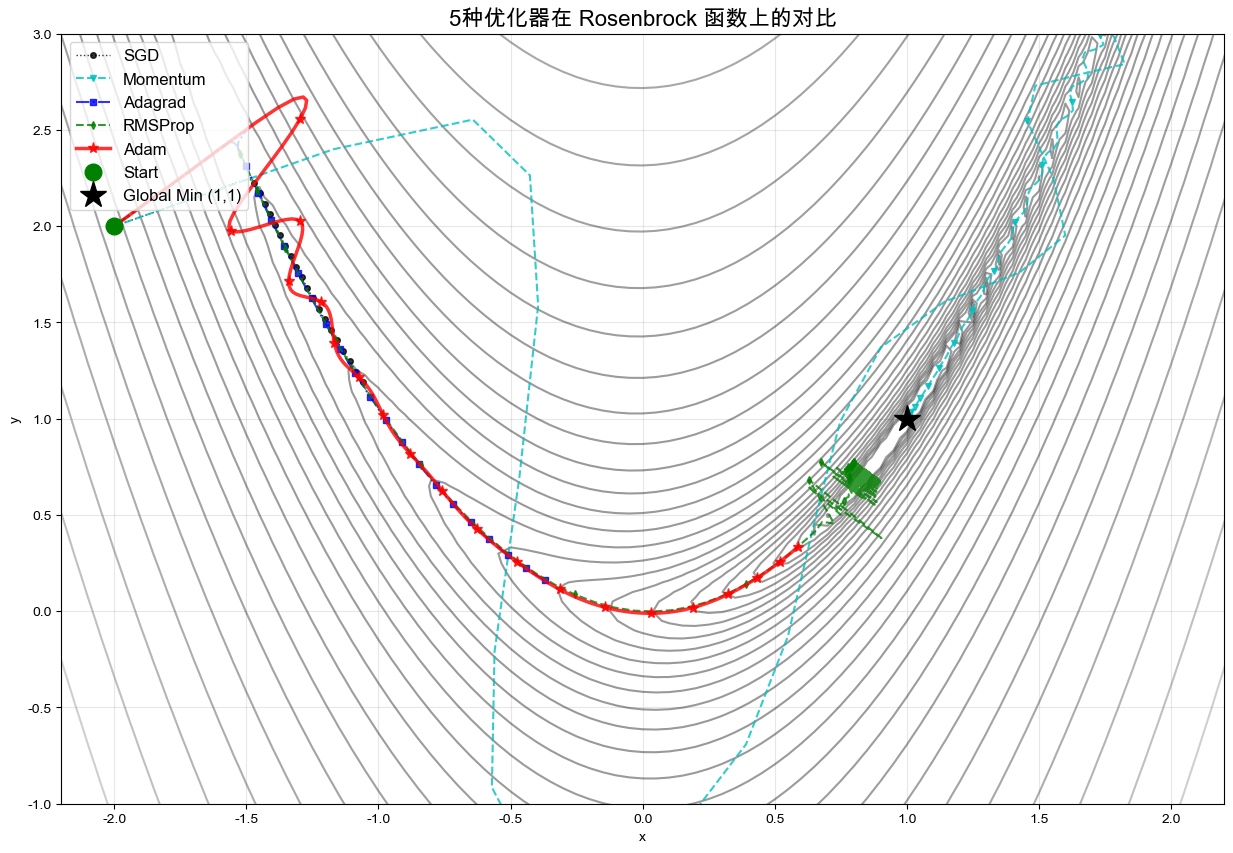

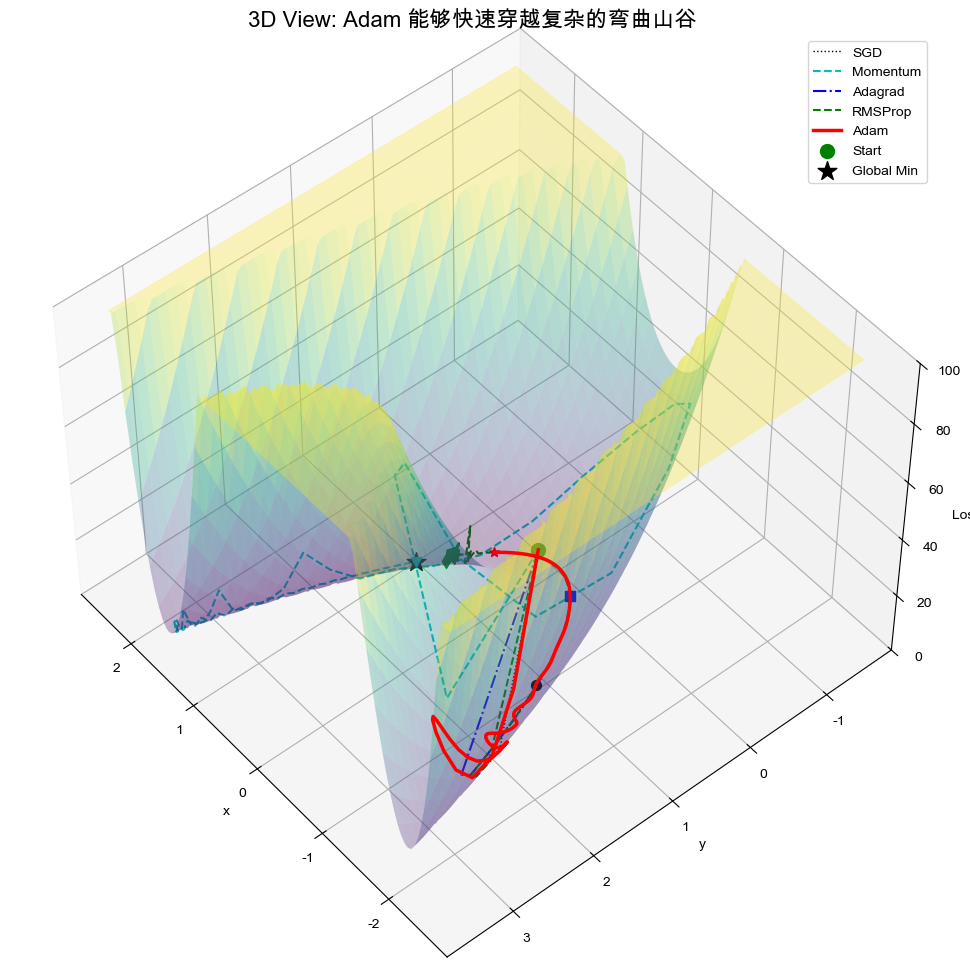

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# ---------------------------
# 设置Matplotlib支持中文
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS', 'SimHei'] 
plt.rcParams['axes.unicode_minus'] = False 
# ---------------------------

# --- 1. 定义损失函数 ---
# Rosenbrock 函数: f(x, y) = (a-x)^2 + b(y-x^2)^2
# 这里取 a=1, b=20 (标准是100，取20让梯度不至于过大，方便可视化)
def loss_function(x, y):
    return (1 - x)**2 + 20 * (y - x**2)**2

def gradients(x, y):
    # df/dx = -2(1-x) - 4b*x*(y-x^2)
    # df/dy = 2b*(y-x^2)
    grad_x = -2 * (1 - x) - 40 * x * (y - x**2)
    grad_y = 40 * (y - x**2)
    return grad_x, grad_y

# --- 2. 定义优化器类 ---
# 为了方便管理，我们用类或者简单的函数闭包来管理状态

class Optimizer:
    def __init__(self, name, lr, start_pos, num_epochs=100):
        self.name = name
        self.lr = lr
        self.x = start_pos[0]
        self.y = start_pos[1]
        self.history = [(self.x, self.y)]
        self.num_epochs = num_epochs
    
    def step(self):
        pass

    def run(self):
        for _ in range(self.num_epochs):
            self.step()
            self.history.append((self.x, self.y))
        return self.history

# 1. SGD (Gradient Descent)
class SGD(Optimizer):
    def __init__(self, lr, start_pos, **kwargs):
        super().__init__("SGD", lr, start_pos, **kwargs)

    def step(self):
        g_x, g_y = gradients(self.x, self.y)
        self.x -= self.lr * g_x
        self.y -= self.lr * g_y

# 2. Momentum
class Momentum(Optimizer):
    def __init__(self, lr, start_pos, gamma=0.9, **kwargs):
        super().__init__("Momentum", lr, start_pos, **kwargs)
        self.gamma = gamma
        self.v_x = 0
        self.v_y = 0
        
    def step(self):
        g_x, g_y = gradients(self.x, self.y)
        self.v_x = self.gamma * self.v_x + self.lr * g_x
        self.v_y = self.gamma * self.v_y + self.lr * g_y
        self.x -= self.v_x
        self.y -= self.v_y

# 3. Adagrad
class Adagrad(Optimizer):
    def __init__(self, lr, start_pos, epsilon=1e-8, **kwargs):
        super().__init__("Adagrad", lr, start_pos, **kwargs)
        self.h_x = 0
        self.h_y = 0
        self.epsilon = epsilon
        
    def step(self):
        g_x, g_y = gradients(self.x, self.y)
        self.h_x += g_x**2
        self.h_y += g_y**2
        self.x -= (self.lr / (np.sqrt(self.h_x) + self.epsilon)) * g_x
        self.y -= (self.lr / (np.sqrt(self.h_y) + self.epsilon)) * g_y

# 4. RMSProp
class RMSProp(Optimizer):
    def __init__(self, lr, start_pos, decay=0.9, epsilon=1e-8, **kwargs):
        super().__init__("RMSProp", lr, start_pos, **kwargs)
        self.h_x = 0
        self.h_y = 0
        self.decay = decay
        self.epsilon = epsilon
        
    def step(self):
        g_x, g_y = gradients(self.x, self.y)
        self.h_x = self.decay * self.h_x + (1 - self.decay) * g_x**2
        self.h_y = self.decay * self.h_y + (1 - self.decay) * g_y**2
        self.x -= (self.lr / (np.sqrt(self.h_x) + self.epsilon)) * g_x
        self.y -= (self.lr / (np.sqrt(self.h_y) + self.epsilon)) * g_y

# 5. Adam
class Adam(Optimizer):
    def __init__(self, lr, start_pos, beta1=0.9, beta2=0.999, epsilon=1e-8, **kwargs):
        super().__init__("Adam", lr, start_pos, **kwargs)
        self.m_x, self.m_y = 0, 0
        self.v_x, self.v_y = 0, 0
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.t = 0
        
    def step(self):
        self.t += 1
        g_x, g_y = gradients(self.x, self.y)
        
        # Momentum
        self.m_x = self.beta1 * self.m_x + (1 - self.beta1) * g_x
        self.m_y = self.beta1 * self.m_y + (1 - self.beta1) * g_y
        
        # RMSProp
        self.v_x = self.beta2 * self.v_x + (1 - self.beta2) * g_x**2
        self.v_y = self.beta2 * self.v_y + (1 - self.beta2) * g_y**2
        
        # Bias correction
        m_hat_x = self.m_x / (1 - self.beta1**self.t)
        m_hat_y = self.m_y / (1 - self.beta1**self.t)
        v_hat_x = self.v_x / (1 - self.beta2**self.t)
        v_hat_y = self.v_y / (1 - self.beta2**self.t)
        
        # Update
        self.x -= self.lr * m_hat_x / (np.sqrt(v_hat_x) + self.epsilon)
        self.y -= self.lr * m_hat_y / (np.sqrt(v_hat_y) + self.epsilon)

# --- 3. 运行优化器 ---
start_pos = (-2.0, 2.0) # 起始点，在山谷的一侧
epochs = 200 # 迭代次数

# 不同优化器的学习率需要精细调整以展示最佳效果
optimizers = [
    SGD(lr=0.002, start_pos=start_pos, num_epochs=epochs),      # SGD必须很慢，否则飞出山谷
    Momentum(lr=0.005, start_pos=start_pos, num_epochs=epochs), # Momentum可以快一点
    Adagrad(lr=0.5, start_pos=start_pos, num_epochs=epochs),    # Adagrad需要大LR
    RMSProp(lr=0.1, start_pos=start_pos, num_epochs=epochs),    # RMSProp适中
    Adam(lr=0.15, start_pos=start_pos, num_epochs=epochs)       # Adam通常表现最稳健
]

results = {}
for opt in optimizers:
    results[opt.name] = opt.run()
    
# --- 4. 2D 可视化 ---
X_range = np.arange(-2.5, 2.5, 0.05)
Y_range = np.arange(-1.5, 3.5, 0.05)
X, Y = np.meshgrid(X_range, Y_range)
Z = loss_function(X, Y)

plt.figure(figsize=(15, 10))

# 绘制等高线，使用对数刻度让山谷更清晰
contour = plt.contour(X, Y, Z, levels=np.logspace(-1, 3, 30), cmap='gray', alpha=0.4)
# plt.clabel(contour, inline=True, fontsize=8)

colors = {'SGD': 'k', 'Momentum': 'c', 'Adagrad': 'b', 'RMSProp': 'g', 'Adam': 'r'}
markers = {'SGD': 'o', 'Momentum': 'v', 'Adagrad': 's', 'RMSProp': 'd', 'Adam': '*'}
linestyles = {'SGD': ':', 'Momentum': '--', 'Adagrad': '-.', 'RMSProp': '--', 'Adam': '-'}
linewidths = {'SGD': 1, 'Momentum': 1.5, 'Adagrad': 1.5, 'RMSProp': 1.5, 'Adam': 2.5}

for name, history in results.items():
    x_traj = [p[0] for p in history]
    y_traj = [p[1] for p in history]
    
    plt.plot(x_traj, y_traj, 
             color=colors[name], 
             linestyle=linestyles[name],
             linewidth=linewidths[name],
             marker=markers[name],
             markersize=4 if name != 'Adam' else 8,
             markevery=10,
             label=name,
             alpha=0.8)

# 标记起点和终点
plt.plot(start_pos[0], start_pos[1], 'go', markersize=12, label='Start')
plt.plot(1, 1, 'k*', markersize=20, label='Global Min (1,1)')

plt.xlabel('x')
plt.ylabel('y')
plt.title(f'5种优化器在 Rosenbrock 函数上的对比', fontsize=16)
plt.legend(loc='upper left', fontsize=12)
plt.grid(True, alpha=0.3)
plt.xlim(-2.2, 2.2)
plt.ylim(-1.0, 3.0)

plt.show()

# --- 5. 3D 可视化 ---
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111, projection='3d')

# 绘制表面 (为了看清，Z轴截断)
Z_surf = Z.copy()
Z_surf[Z_surf > 100] = 100 # 截断高处，避免遮挡
surf = ax.plot_surface(X, Y, Z_surf, cmap='viridis', alpha=0.3, edgecolor='none')

for name, history in results.items():
    x_traj = [p[0] for p in history]
    y_traj = [p[1] for p in history]
    z_traj = [loss_function(p[0], p[1]) for p in history]
    
    # 将 Adam 放在最上层绘制
    z_order = 100 if name == 'Adam' else 1
    
    ax.plot(x_traj, y_traj, z_traj, 
            color=colors[name], 
            linestyle=linestyles[name],
            linewidth=linewidths[name],
            label=name,
            zorder=z_order)
    
    # 终点标记
    ax.scatter([x_traj[-1]], [y_traj[-1]], [z_traj[-1]], c=colors[name], s=50, marker=markers[name])

# 标记起点和终点
ax.scatter([start_pos[0]], [start_pos[1]], [loss_function(*start_pos)], c='g', s=100, label='Start')
ax.scatter([1], [1], [0], c='k', marker='*', s=200, label='Global Min')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('Loss')
ax.set_title('3D View: Adam 能够快速穿越复杂的弯曲山谷', fontsize=16)

# 调整视角
ax.view_init(elev=50, azim=140)
ax.set_zlim(0, 100) # 限制Z轴

plt.legend()
plt.show()

In [ ]:
# --- 6. 交互式 3D 可视化 (需要安装 plotly) ---
# pip install plotly

try:
    import plotly.graph_objects as go

    fig = go.Figure()

    # 1. 绘制 Loss Surface
    # 截断 Z 轴以便观察
    Z_clipped = Z.copy()
    Z_clipped[Z_clipped > 100] = 100
    
    fig.add_trace(go.Surface(z=Z_clipped, x=X, y=Y, colorscale='Viridis', opacity=0.7, name='Loss Surface', showscale=False))

    # 2. 绘制轨迹
    colors_plotly = {'SGD': 'black', 'Momentum': 'cyan', 'Adagrad': 'blue', 'RMSProp': 'green', 'Adam': 'red'}
    
    for name, history in results.items():
        x_traj = [p[0] for p in history]
        y_traj = [p[1] for p in history]
        z_traj = [loss_function(p[0], p[1]) for p in history]
        
        # 为了让线稍微浮在表面之上，避免重叠
        z_traj_lifted = [z + 0.5 for z in z_traj]

        line_width = 5 if name == 'Adam' else 3
        
        fig.add_trace(go.Scatter3d(
            x=x_traj, y=y_traj, z=z_traj_lifted,
            mode='lines',
            name=name,
            line=dict(color=colors_plotly[name], width=line_width)
        ))
        
        # 终点
        fig.add_trace(go.Scatter3d(
            x=[x_traj[-1]], y=[y_traj[-1]], z=[z_traj[-1]],
            mode='markers',
            name=f'{name} End',
            marker=dict(size=4, color=colors_plotly[name]),
            showlegend=False
        ))

    # 3. 标记起点和终点
    fig.add_trace(go.Scatter3d(
        x=[start_pos[0]], y=[start_pos[1]], z=[loss_function(*start_pos)],
        mode='markers', name='Start', marker=dict(size=8, color='green', symbol='circle')
    ))

    fig.add_trace(go.Scatter3d(
        x=[1], y=[1], z=[0],
        mode='markers', name='Global Min', marker=dict(size=8, color='black', symbol='diamond')
    ))

    # 布局设置
    fig.update_layout(
        title='3D Interactive Optimizer Comparison (可拖拽旋转)',
        scene=dict(
            xaxis_title='X',
            yaxis_title='Y',
            zaxis_title='Loss',
            zaxis=dict(range=[0, 100]), # 限制 Z 轴高度
            camera=dict(
                eye=dict(x=1.5, y=1.5, z=1.2)
            )
        ),
        width=900,
        height=700,
        margin=dict(l=0, r=0, b=0, t=40)
    )

    fig.show()

except ImportError:
    print("请安装 plotly 以查看交互式图表: pip install plotly")